In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

dataset_APPLE = "/aiffel/aiffel/stock_prediction/data/AAPL.csv"
dataset_IBM = "/aiffel/aiffel/stock_prediction/data/IBM.csv"
dataset_SONY = "/aiffel/aiffel/stock_prediction/data/SONY.csv"
df_APPLE = pd.read_csv(dataset_APPLE)
df_IBM = pd.read_csv(dataset_IBM)
df_SONY = pd.read_csv(dataset_SONY)
ts_APPLE = df_APPLE['Close']
ts_IBM = df_IBM['Close']
ts_SONY = df_SONY['Close']


In [2]:
ts_APPLE.head()

0    148.559998
1    148.990005
2    146.770004
3    144.979996
4    145.639999
Name: Close, dtype: float64

In [3]:
ts_IBM.head()

0    135.124283
1    136.491394
2    136.472275
3    135.535370
4    135.688339
Name: Close, dtype: float64

In [4]:
ts_SONY.head()

0    100.660004
1     99.290001
2     99.629997
3    103.129997
4    105.860001
Name: Close, dtype: float64

APPLE, IBM, SONY 의 데이터를 사용해보자

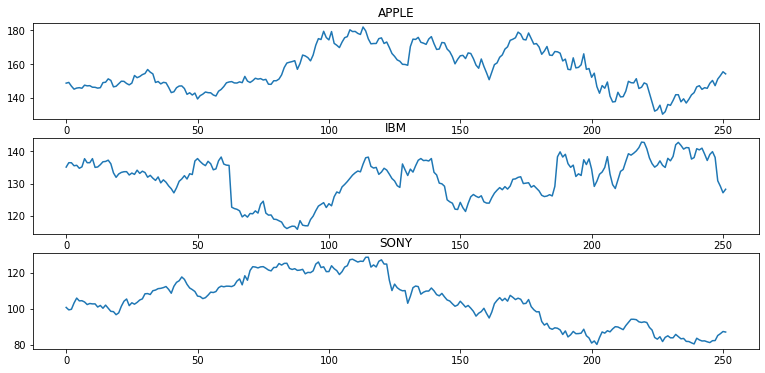

In [5]:
from matplotlib.pyplot import rcParams
rcParams['figure.figsize'] = 13, 6

plt.subplot(311)
plt.plot(ts_APPLE)
plt.title('APPLE')
plt.subplot(312)
plt.plot(ts_IBM)
plt.title('IBM')
plt.subplot(313)
plt.plot(ts_SONY)
plt.title('SONY')
plt.show()


본격적으로 데이터를 분석하기에 앞서 결측치가 있는지 확인한다.

In [6]:
print(ts_APPLE[ts_APPLE.isna()])
print(ts_IBM[ts_IBM.isna()])
print(ts_SONY[ts_SONY.isna()])

Series([], Name: Close, dtype: float64)
Series([], Name: Close, dtype: float64)
Series([], Name: Close, dtype: float64)


세 데이터에 로그값을 취해준다

In [7]:
ts_APPLE_log = np.log(ts_APPLE)
ts_IBM_log = np.log(ts_IBM)
ts_SONY_log = np.log(ts_SONY)

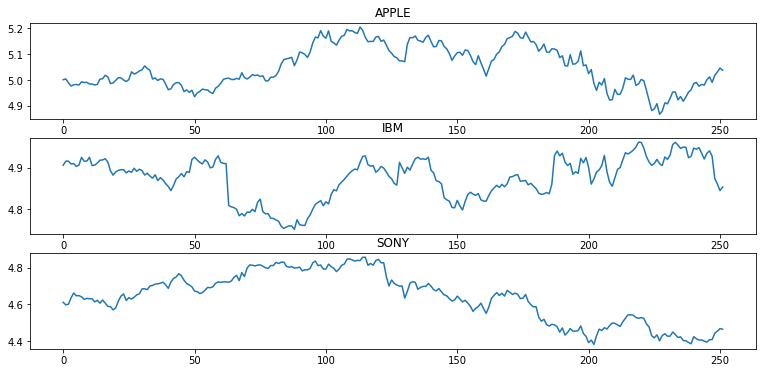

In [8]:
plt.subplot(311)
plt.plot(ts_APPLE_log)
plt.title('APPLE')
plt.subplot(312)
plt.plot(ts_IBM_log)
plt.title('IBM')
plt.subplot(313)
plt.plot(ts_SONY_log)
plt.title('SONY')
plt.show()

`plot_rolling_statistics` 라는 기존 그래프, 이동 평균과 표준편차 그래프를 그려주는 함수를 사용한다

In [9]:
def plot_rolling_statistics(timeseries, window=30):
    
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()    
    
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='ROlling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('ROlling Mean & Standard Deviation')
    plt.show(block=False)
    

로그를 취하기 전의 이동평균, 편차를 보면 다음과 같다

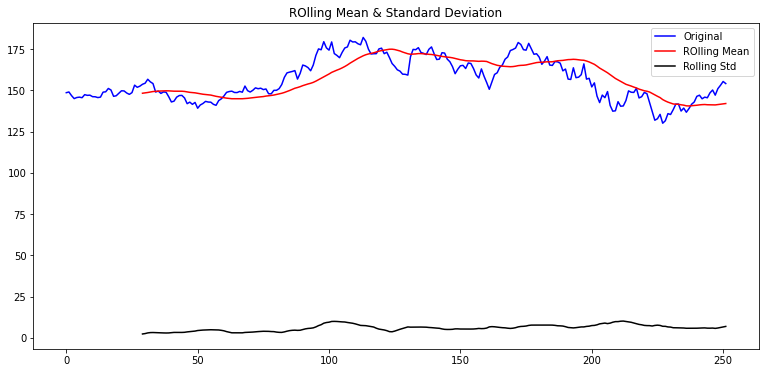

In [10]:
plot_rolling_statistics(ts_APPLE)

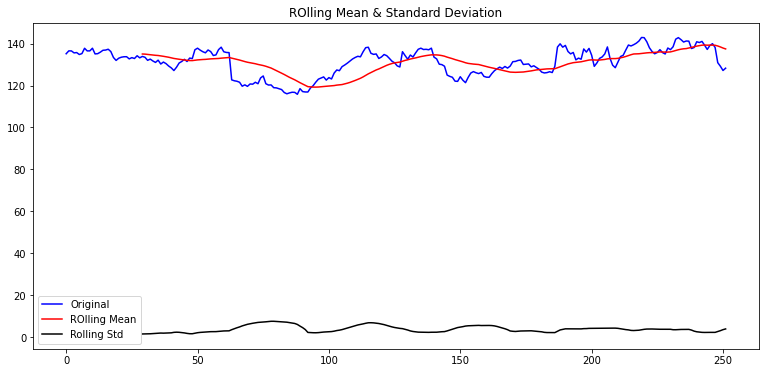

In [11]:
plot_rolling_statistics(ts_IBM)

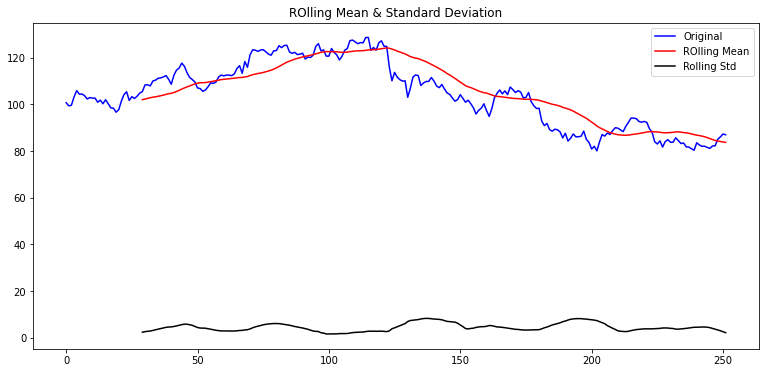

In [12]:
plot_rolling_statistics(ts_SONY)

로그를 취한 후의 그래프는 다음과 같다

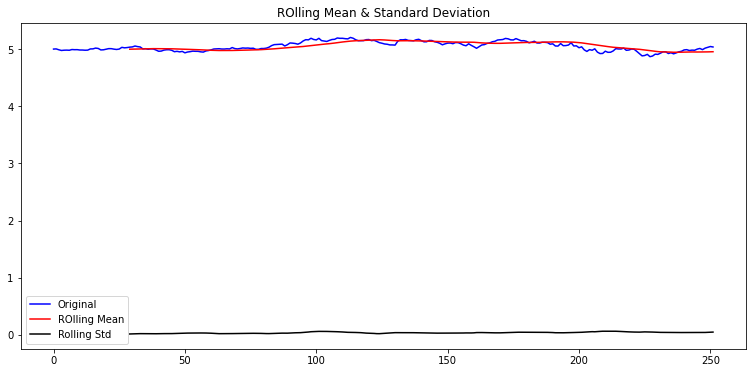

In [13]:
plot_rolling_statistics(ts_APPLE_log)

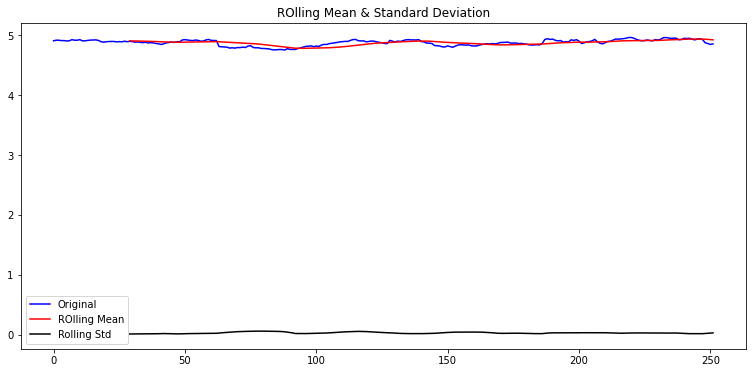

In [14]:
plot_rolling_statistics(ts_IBM_log)

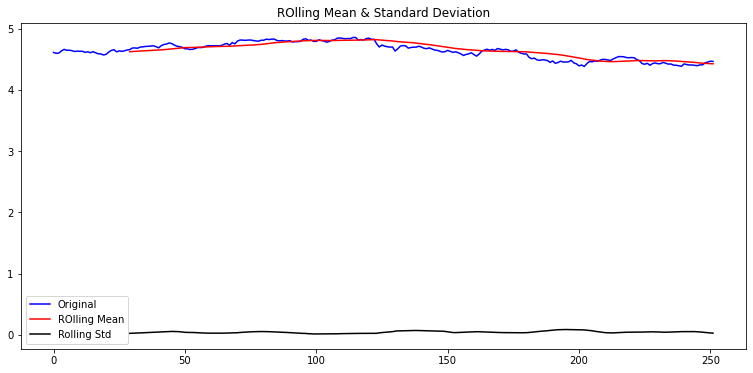

In [15]:
plot_rolling_statistics(ts_SONY_log)

시계열 데이터의 p값을 측정하는 statsmodels.tsa.stattolls 라이브러리의 adfuller 함수를 사용한다}

In [16]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [17]:
augmented_dickey_fuller_test(ts_APPLE_log)
augmented_dickey_fuller_test(ts_IBM_log)
augmented_dickey_fuller_test(ts_SONY_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.919845
p-value                          0.322784
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -2.708732
p-value                          0.072539
#Lags Used                       1.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -0.800718
p-value                          0.818911
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.57

각각 p-value가 0.3, 0.07, 0.8 로 아직 전처리가 조금 더 필요하다고 볼 수 있다. statsmodels.tsa.seasonal 라이브러리의 seasonal_decompose 함수를 사용하여 trend와 seasonality를 제거한 residual의 p-value를 구해 보자

각 데이터는 날짜 별 종료 주식값을 의미하므로 period를 30으로 설정함이 적절하다

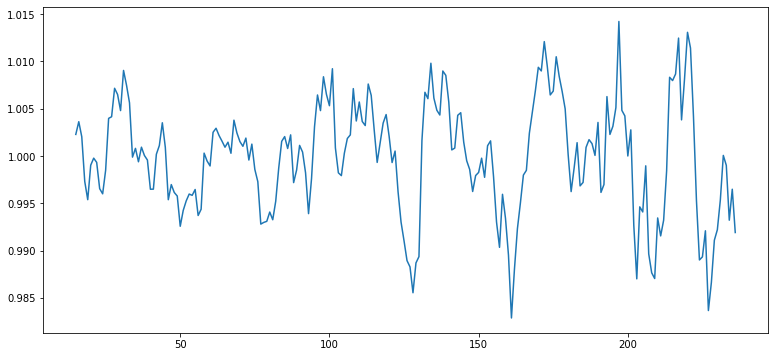

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose
dp_APPLE = seasonal_decompose(ts_APPLE_log, model='multiplicative', period=30)
rd_APPLE = dp_APPLE.resid
plt.plot(rd_APPLE)
plt.show()

rd_APPLE의 이동평균, 이동편차를 그래프로 나타내어 보고, 그 p-value를 구해보자

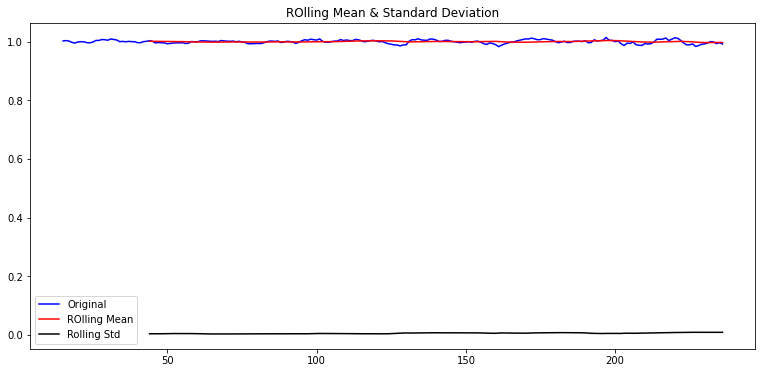

In [19]:
plot_rolling_statistics(rd_APPLE)

이동 통계치를 구하는 과정에서 필연적으로 결측치가 발생하므로, 이를 제거하는 코드가 필요하다

In [20]:
rd_APPLE.dropna(inplace=True)
augmented_dickey_fuller_test(rd_APPLE)

Results of Dickey-Fuller Test:
Test Statistic                  -4.583487
p-value                          0.000139
#Lags Used                      11.000000
Number of Observations Used    210.000000
Critical Value (1%)             -3.461879
Critical Value (5%)             -2.875404
Critical Value (10%)            -2.574159
dtype: float64


p-value가 0.000139로 이제 안정적 시계열로 봐도 무방할 듯 하다. 남은 IBM, SONY에 대해서도 같은 과정을 반복해 보자

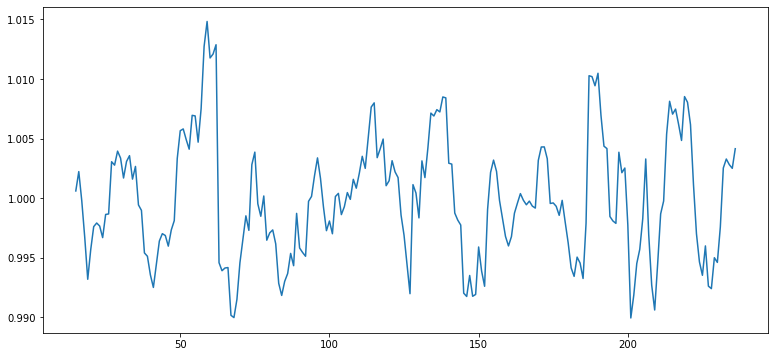

In [21]:
dp_IBM = seasonal_decompose(ts_IBM_log, model='multiplicative', period=30)
rd_IBM = dp_IBM.resid
plt.plot(rd_IBM)
plt.show()

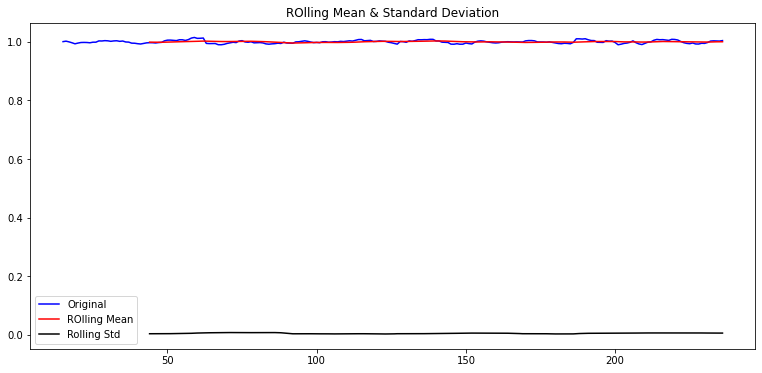

In [22]:
plot_rolling_statistics(rd_IBM)

In [23]:
rd_IBM.dropna(inplace=True)
augmented_dickey_fuller_test(rd_IBM)

Results of Dickey-Fuller Test:
Test Statistic                -6.191975e+00
p-value                        6.091795e-08
#Lags Used                     8.000000e+00
Number of Observations Used    2.130000e+02
Critical Value (1%)           -3.461429e+00
Critical Value (5%)           -2.875207e+00
Critical Value (10%)          -2.574054e+00
dtype: float64


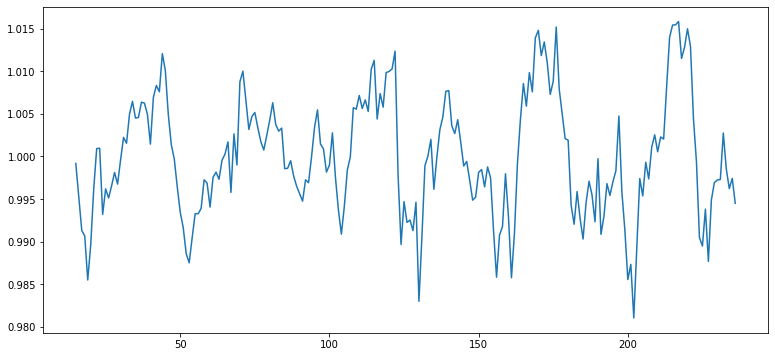

In [24]:
dp_SONY = seasonal_decompose(ts_SONY_log, model='multiplicative', period=30)
rd_SONY = dp_SONY.resid
plt.plot(rd_SONY)
plt.show()

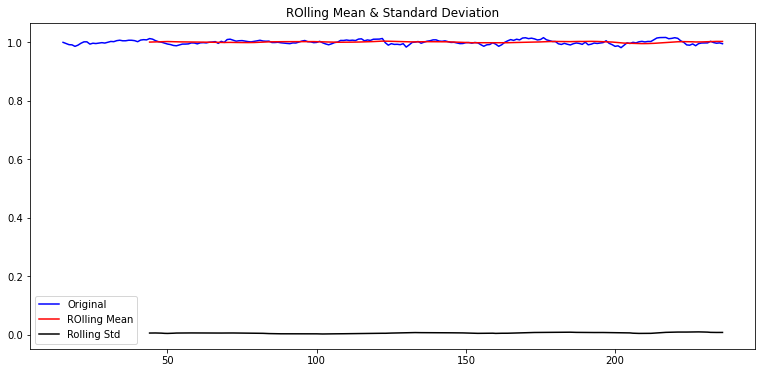

In [25]:
plot_rolling_statistics(rd_SONY)

In [26]:
rd_SONY.dropna(inplace=True)
augmented_dickey_fuller_test(rd_SONY)

Results of Dickey-Fuller Test:
Test Statistic                -5.770695e+00
p-value                        5.401069e-07
#Lags Used                     1.400000e+01
Number of Observations Used    2.070000e+02
Critical Value (1%)           -3.462342e+00
Critical Value (5%)           -2.875606e+00
Critical Value (10%)          -2.574267e+00
dtype: float64


IBM, SONY 모두 Trend와 Seasonality를 제거한 Residual에서 p-value가 매우 작아진 모습을 확인하였다. 이제 ARIMA 모델에 적용하기 충분한 안정성을 갖추었다고 보아도 무방할 것이다.

학습을 진행하고 이를 테스트하기위해 데이터를 train, test로 나누어 주자

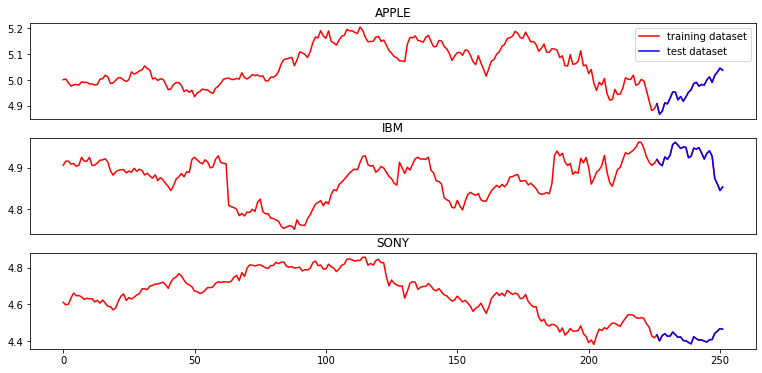

In [27]:
train_APPLE_data, test_APPLE_data = ts_APPLE_log[:int(len(ts_APPLE_log)*0.9)], ts_APPLE_log[int(len(ts_APPLE_log)*0.9):]
train_IBM_data, test_IBM_data = ts_IBM_log[:int(len(ts_IBM_log)*0.9)], ts_IBM_log[int(len(ts_IBM_log)*0.9):]
train_SONY_data, test_SONY_data = ts_SONY_log[:int(len(ts_SONY_log)*0.9)], ts_SONY_log[int(len(ts_SONY_log)*0.9):]

plt.subplot(311)
# plt.grid(True)
plt.plot(ts_APPLE_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_APPLE_data, c='b', label='test dataset')
plt.title('APPLE')
plt.xticks([])
plt.legend()

plt.subplot(312)
# plt.grid(True)
plt.plot(ts_IBM_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_IBM_data, c='b', label='test dataset')
plt.title('IBM')
plt.xticks([])

# plt.legend()

plt.subplot(313)
# plt.grid(True)
plt.plot(ts_SONY_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_SONY_data, c='b', label='test dataset')
plt.title('SONY')
# plt.legend()

plt.show()


ARIMA 모델의 P, d, q값을 결정하기 위해 ACF, PACF 그래프를 그려보자

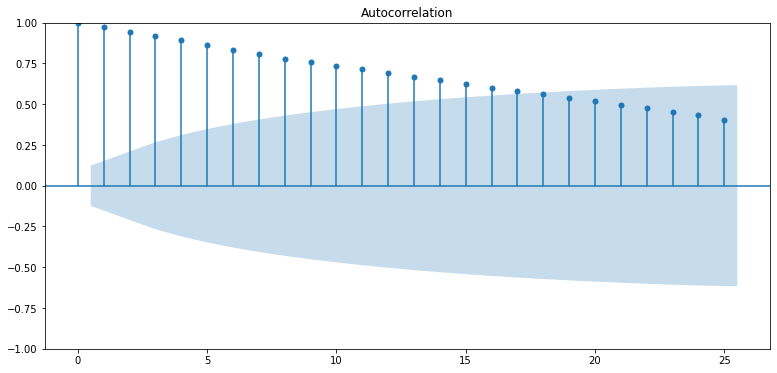

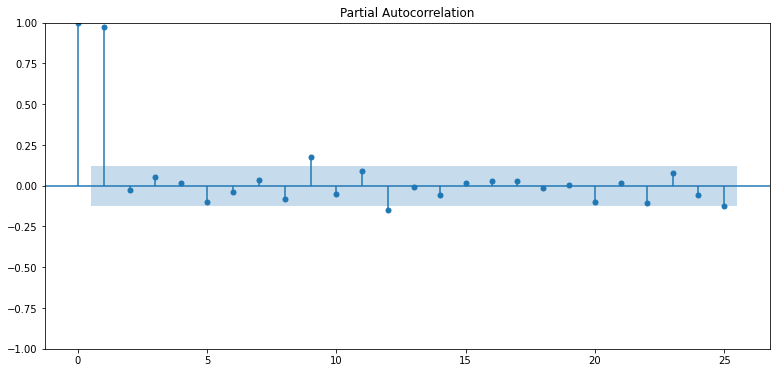

In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

plot_acf(ts_APPLE_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_APPLE_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.553513e+01
p-value                        2.195111e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


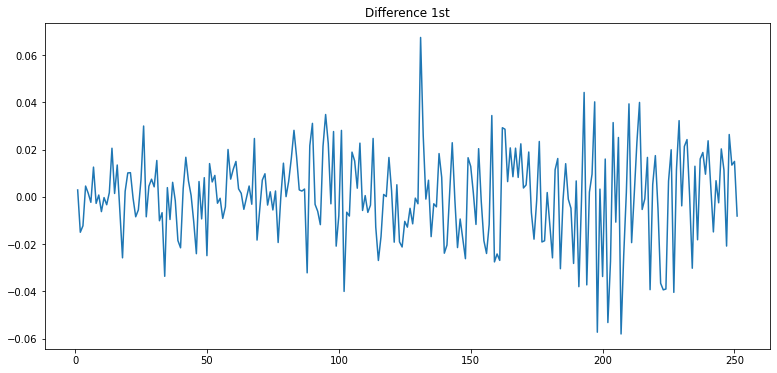

In [29]:
# 1차 차분 구하기
diff_1 = ts_APPLE_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

ACF가 점진적으로 감소하고 PACF는 p=1 이후 급격히 감소한다. 또한 1차 차분을 구한 후 p값이 e-28수준으로 감소하였으므로 APPLE의 pdq 값은 (1, 1, 0)이 적합하다.

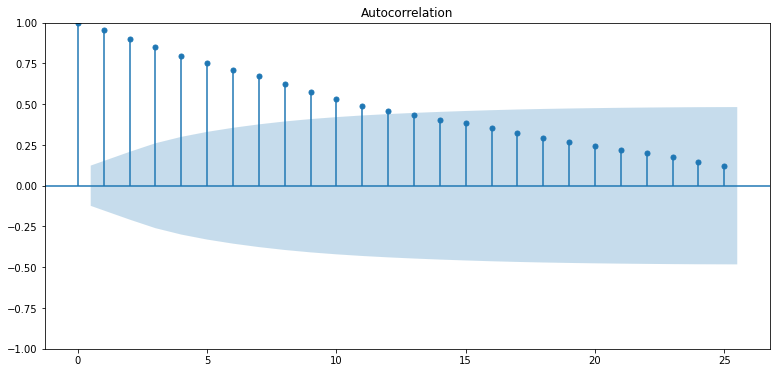

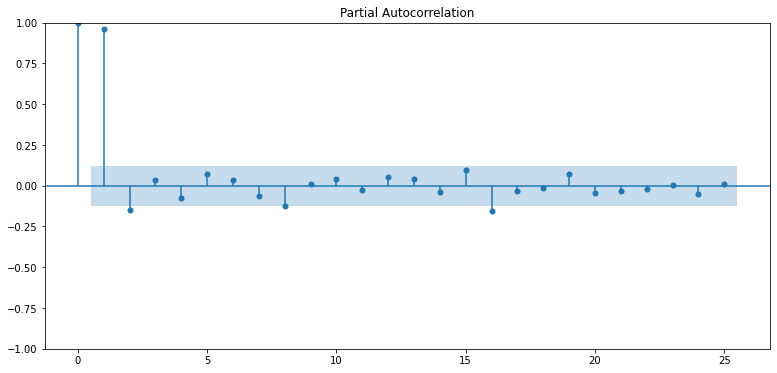

In [30]:
plot_acf(ts_IBM_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_IBM_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.418518e+01
p-value                        1.898304e-26
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64


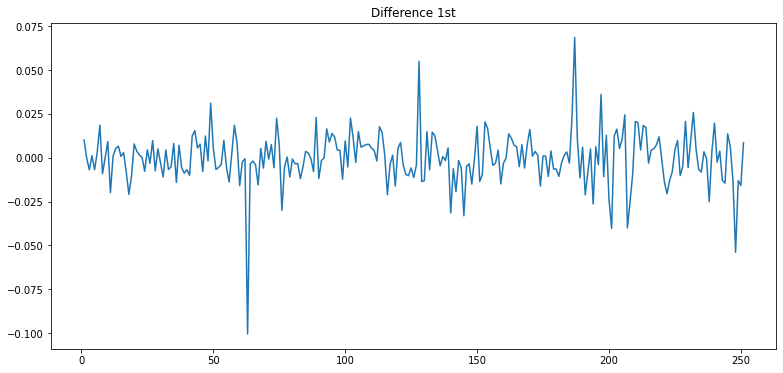

In [31]:
# 1차 차분 구하기
diff_1 = ts_IBM_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

IBM 도 APPLE과 마찬가지로 pdq = (1, 1, 0)

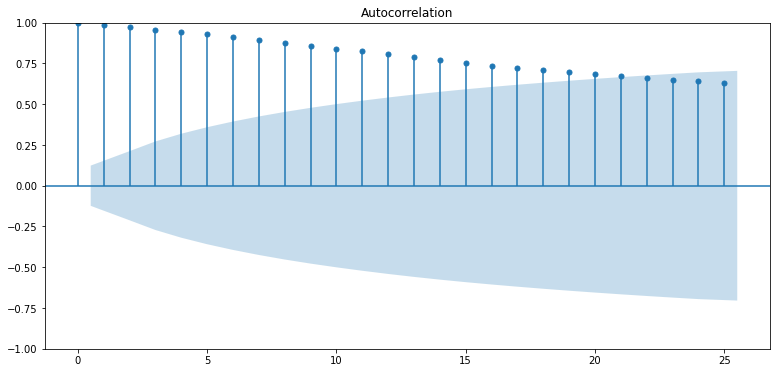

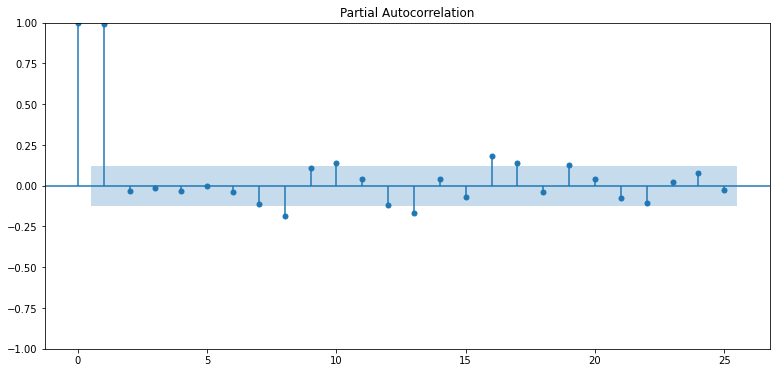

In [32]:
plot_acf(ts_SONY_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_SONY_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -5.279738
p-value                          0.000006
#Lags Used                       8.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64


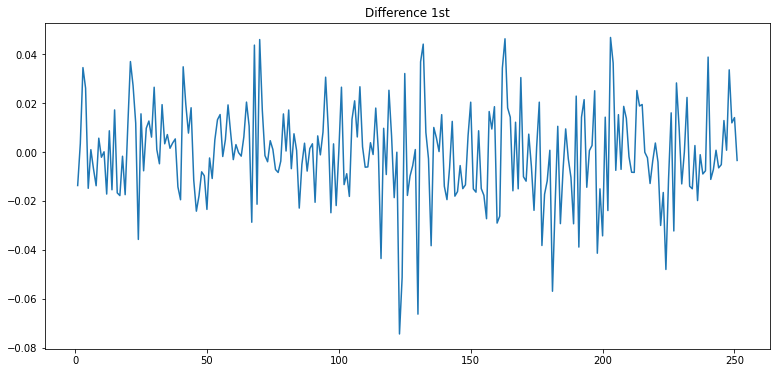

In [33]:
# 1차 차분 구하기
diff_1 = ts_SONY_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -6.025874e+00
p-value                        1.456440e-07
#Lags Used                     1.300000e+01
Number of Observations Used    2.360000e+02
Critical Value (1%)           -3.458366e+00
Critical Value (5%)           -2.873866e+00
Critical Value (10%)          -2.573339e+00
dtype: float64


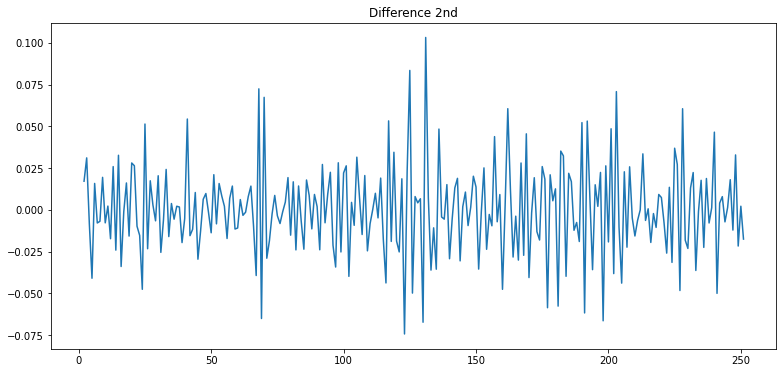

In [34]:
# 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

SONY의 경우 1차 차분의 P-value도 1e-6 수준이고 2차 차분의 값도 1e-7 수준이라 일단 pdq = (1, 2, 0)으로 생각해보자

ARIMA 모델에 각 주가의 시계열 데이터를 넣어 모델을 학습시켜보자

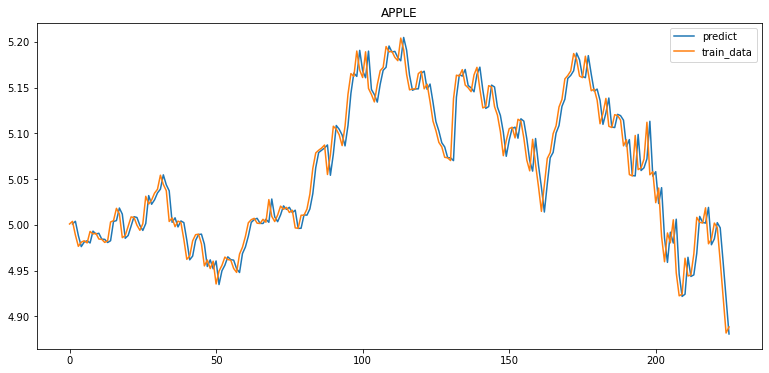

In [35]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_APPLE_data, order=(1, 1, 0)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit()
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_APPLE_data, label='train_data')
plt.title('APPLE')
plt.legend()
plt.show()

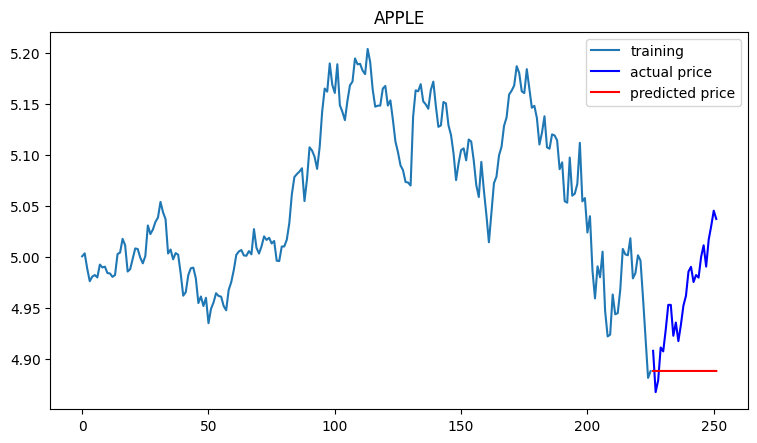

In [36]:
model = ARIMA(train_APPLE_data, order=(1, 1, 0))  
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_APPLE_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_APPLE_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_APPLE_data, label='training')
plt.plot(test_APPLE_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.title('APPLE')
plt.show()

In [37]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_APPLE_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_APPLE_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_APPLE_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_APPLE_data))/np.abs(np.exp(test_APPLE_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  147.6705804043754
MAE:  10.422044753345261
RMSE:  12.151978456382128
MAPE: 7.11%


IBM, SONY데이터의 경우에도 같은 방식으로 진행한다.

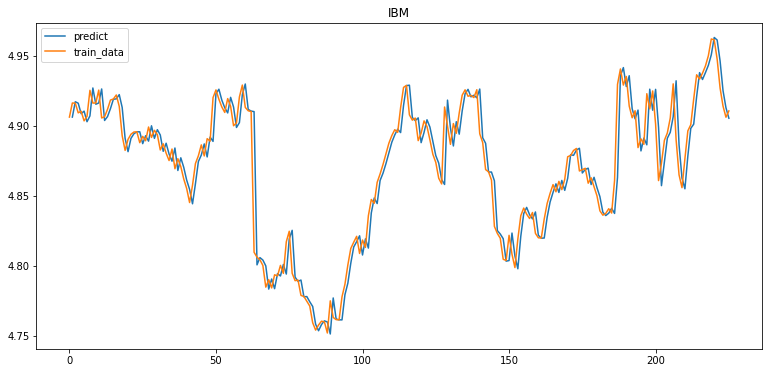

In [38]:
model = ARIMA(train_IBM_data, order=(1, 1, 0)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit()
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_IBM_data, label='train_data')
plt.title('IBM')
plt.legend()
plt.show()

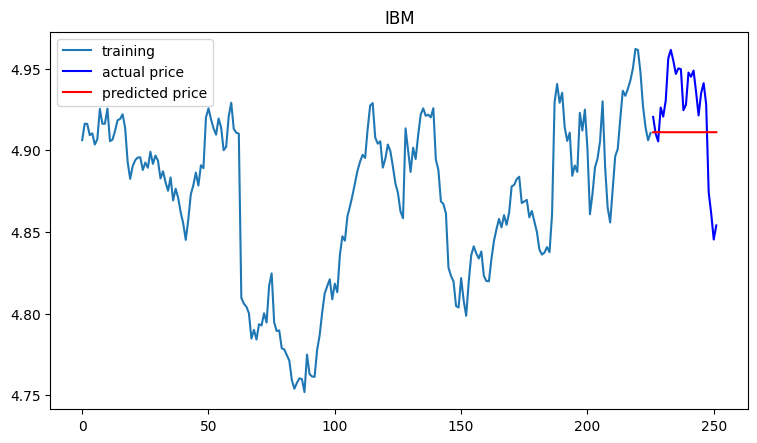

In [39]:
model = ARIMA(train_IBM_data, order=(1, 1, 0))  
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_IBM_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_IBM_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_IBM_data, label='training')
plt.plot(test_IBM_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.title('IBM')
plt.show()

In [40]:
mse = mean_squared_error(np.exp(test_IBM_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_IBM_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_IBM_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_IBM_data))/np.abs(np.exp(test_IBM_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  21.236990439983497
MAE:  4.022023720706871
RMSE:  4.6083609277034165
MAPE: 2.94%


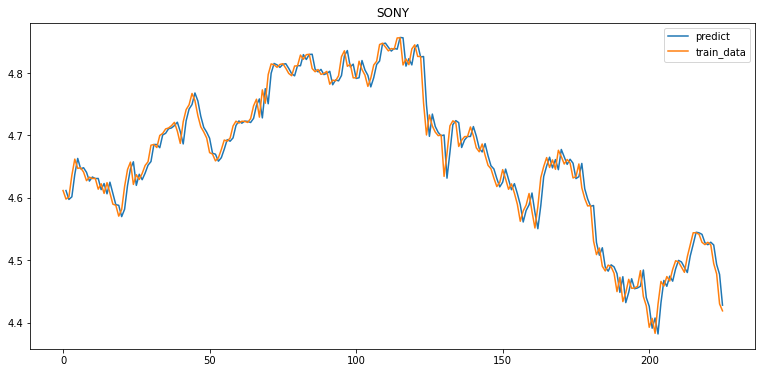

In [41]:
model = ARIMA(train_SONY_data, order=(1, 1, 0)) # 모수는 이전 그래프를 참고 
fitted_m = model.fit()
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_SONY_data, label='train_data')
plt.title('SONY')
plt.legend()
plt.show()

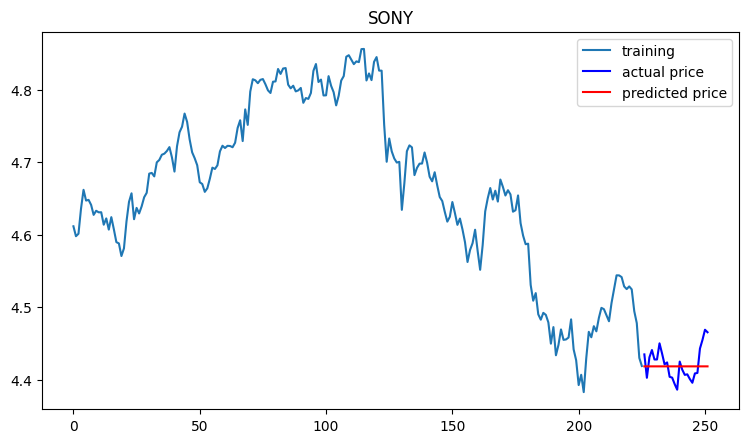

In [42]:
model = ARIMA(train_SONY_data, order=(1, 1, 0))  
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_SONY_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_SONY_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_SONY_data, label='training')
plt.plot(test_SONY_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.title('SONY')
plt.show()

In [43]:
mse = mean_squared_error(np.exp(test_SONY_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_SONY_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_SONY_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_SONY_data))/np.abs(np.exp(test_SONY_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3.476177227248198
MAE:  1.5485284771609698
RMSE:  1.8644509184336813
MAPE: 1.84%


MAPE 값이 APPLE : 7.11 %, IBM : 2.94 %, SONY : 1.84 % 로 목표로 했던 15 % 보다는 낮은 값을 얻었다.

# 회고

아이펠에서 처음 다루어보는 시계열 데이터였다. 그래도 중간의 이동평균, 계졀값, 트랜드 이 정도 내용까지는 흐름을 따라갈 만 했으나 statsmodels의 패키지를 이용하기 시작하고부터는 그냥 그런가부다~ 하고 따라갈 뿐이었다. 한 번 내용을 훑으며 느낀건 이 내용이 하루만에 배울 내용은 절대 아닌듯 하다. 다음 주 금요일 까지 제출이니 금요일 까지 시계열을 열심히 공부하면 모든 내용을 따라갈 수는 있겠지만 시계열 자체에 집중하기보다는 보다 기본적인 데이터 분석에 집중하는 것이 나에게 도움이 되리라 생각한다. 데이터톤도 있기도 하고.. 이번 익스가 시계열은 이런것이구나! 하는 것이 목적이라면 뭐 납득은 간다. 적어도 다음번에 시계열을 볼 때는 이동평균, 계절성, 사이클 등등에 대한 기본적인 개념은 기억하고 있을 테니까..